In [1]:
import torch
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision
import os
import json
import random
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
import time
from torch.nn.functional import softmax

Task 1: Basics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])


plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


dataset_path = "./TestDataSet/TestDataSet"
with open('./TestDataSet/TestDataSet/labels_list.json') as f:
    class_map = json.load(f)

New_map = {m: k for k, m in enumerate(class_map)}
print(New_map.keys())
print(New_map.values())
print(list(New_map.keys())[0])
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, offset=401):
        self.base = base_dataset
        self.offset = offset

    def __getitem__(self, idx):
        img, label = self.base[idx]
        return img, label + self.offset  # remap label

    def __len__(self):
        return len(self.base)
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataset = MyDataset(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
torch.save(dataloader, 'dataloader.pt')

pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)


dict_keys(['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow ti

In [5]:

def evaluate_topk(model, data_loader):
    model.eval()
    
    top1_correct, top5_correct, total = 0, 0, 0
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
          
            outputs = model(imgs)
            probs = softmax(outputs, dim=1)
            
            _, top5 = probs.topk(5, dim=1)
            top1 = top5[:, 0]
            top1_correct += (top1 == labels).sum().item()
            top5_correct += sum([label in top5[i] for i, label in enumerate(labels)])
            total += labels.size(0)
            
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total

   
    print(f"Top 1 - Accuracy: {top1_acc:.4f}%")
    print(f"Top 5 - Accuracy: {top5_acc:.4f}%")
        
    return top1_acc, top5_acc

In [7]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
baseline_acc = evaluate_topk(pretrained_model, dataloader)

Top 1 - Accuracy: 76.0000%
Top 5 - Accuracy: 94.2000%


In [28]:
import math
def unnormalize(img, mean=mean_norms, std=std_norms):
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    return torch.clamp(img, 0, 1)

def visualize_samples(org_dataset, adversarial_dataset=None, num_samples=5):
    # 固定：第一行原图，第二行对抗图，每行 num_samples 张
    idxs = random.sample(range(len(org_dataset)), num_samples)

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 4, 8))  

    if num_samples == 1:
        axes = axes.reshape(2, 1)  # 防止1张图时报错

    for i, idx in enumerate(idxs):
        orig_img, _ = org_dataset[idx]
        orig_img = unnormalize(orig_img)

        axes[0, i].imshow(orig_img.permute(1, 2, 0))
        axes[0, i].set_title("Original", fontsize=20)
        axes[0, i].axis("off")

        if adversarial_dataset:
            adv_img, _ = adversarial_dataset[idx]
            adv_img = unnormalize(adv_img)

            axes[1, i].imshow(adv_img.permute(1, 2, 0))
            axes[1, i].set_title("Adversarial", fontsize=20)
            axes[1, i].axis("off")
        else:
            axes[1, i].axis("off")

    plt.tight_layout(pad=2.0)
    plt.show()

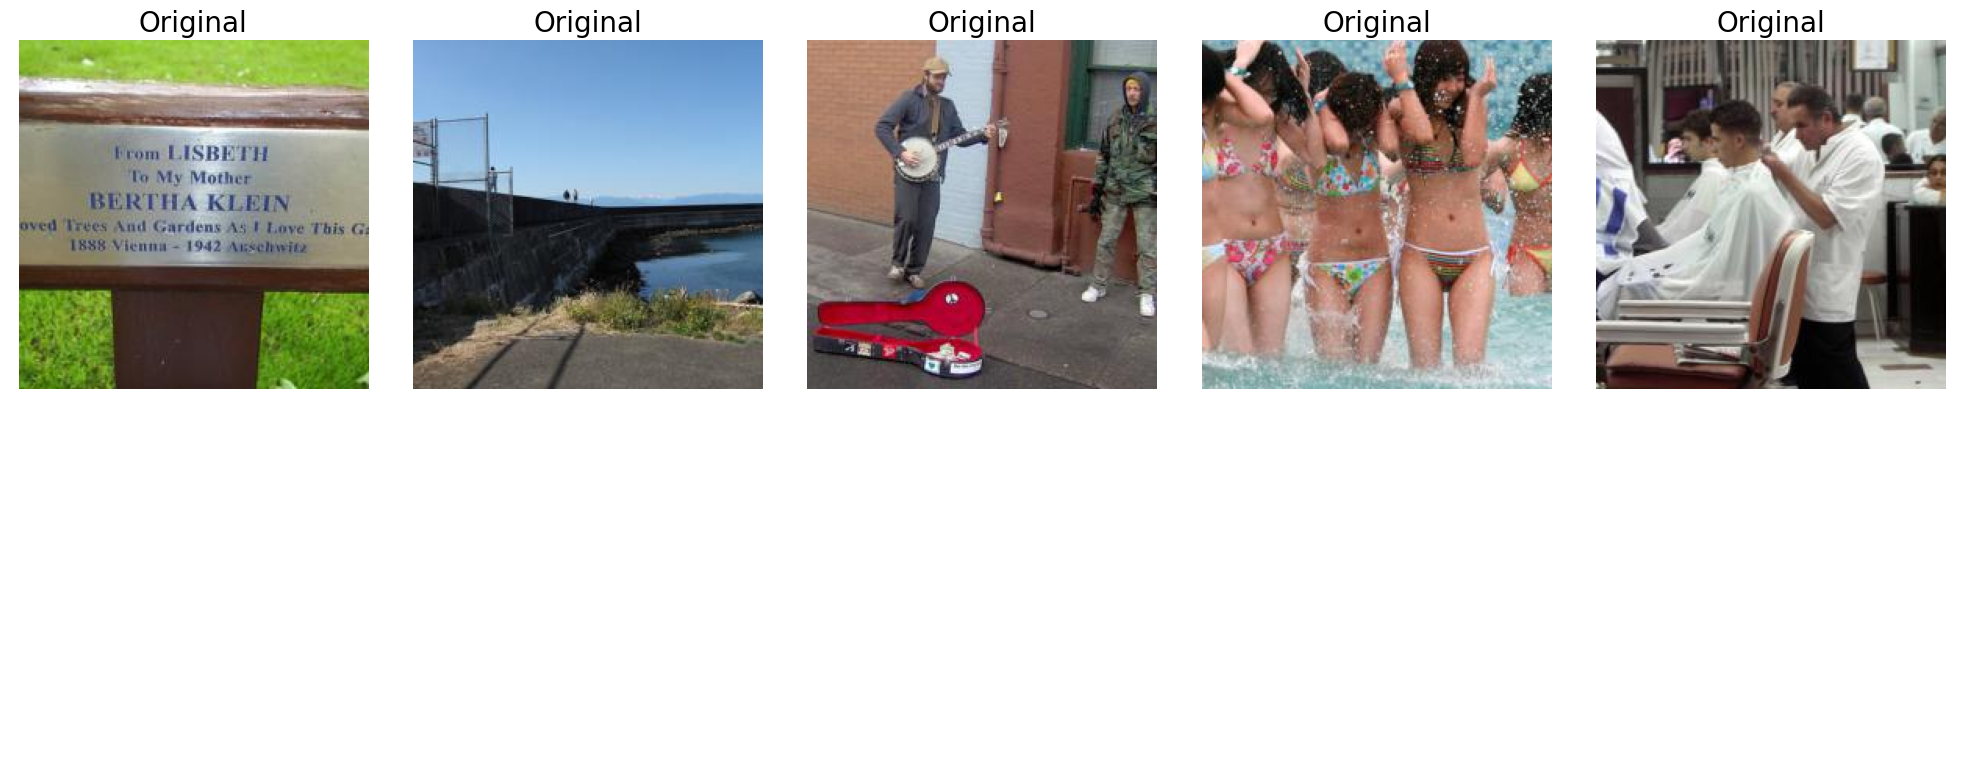

In [9]:
visualize_samples(dataset, num_samples=5)

Task 2: Pixel-wise attacks

In [10]:
def fgsm_attack(model, image, label, epsilon=0.02):
    model.eval().to(device)
    image = image.clone().to(device).detach().requires_grad_(True)
    label = label.to(device)

    output = model(image)
    loss = torch.nn.functional.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()

    perturbation = epsilon * image.grad.sign()
    adv_image = image + perturbation    
    return adv_image.detach()

In [11]:
def evaluate_perturbation(org_dataset, adversarial_dataset):
    max_diffs = []

    for i in range(len(org_dataset)):
        orig_img, _ = org_dataset[i]
        adv_img, _ = adversarial_dataset[i]

        diff = torch.abs(orig_img - adv_img)
        max_diffs.append(diff.max().item())

    max_diff = max(max_diffs)
    max_diff_avg = max_diff / len(max_diffs)
    per_pixel_avg_diff = sum(max_diffs) / len(max_diffs)

    
    print(f"[Perturbation Evaluation]")
    print(f"  • Maximum pixel-wise difference across dataset: {max_diff:.6f}")
    print(f"  • Average maximum difference per image: {max_diff_avg:.6f}")
    print(f"  • Mean per-pixel difference across all samples: {per_pixel_avg_diff:.6f}")

    return max_diff, max_diff_avg, per_pixel_avg_diff


In [14]:
from tqdm import tqdm

adv_images = []
adv_labels = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)

    label_tensor = torch.tensor([label])

    adv_img = fgsm_attack(pretrained_model, img, label_tensor)
    adv_images.append(adv_img.squeeze(0).detach().cpu())
    adv_labels.append(label)

adversarial_test_set_1 = TensorDataset(torch.stack(adv_images), torch.tensor(adv_labels))
Adversarial_Test_Set_1 = DataLoader(adversarial_test_set_1, batch_size=32, shuffle=False)
torch.save(Adversarial_Test_Set_1, 'Adversarial_Test_Set_1.pt')
task_acc = evaluate_topk(pretrained_model, Adversarial_Test_Set_1)

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_acc[1]}%")

evaluate_perturbation(dataset, adversarial_test_set_1)

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 65.68it/s]


Top 1 - Accuracy: 6.0000%
Top 5 - Accuracy: 35.4000%

Accuracy Drop from Baseline
Top-1: 70.0%
Top-5: 58.800000000000004%
[Perturbation Evaluation]
  • Maximum pixel-wise difference across dataset: 0.020000
  • Average maximum difference per image: 0.000040
  • Mean per-pixel difference across all samples: 0.020000


(0.020000100135803223, 4.0000200271606444e-05, 0.020000097334384917)

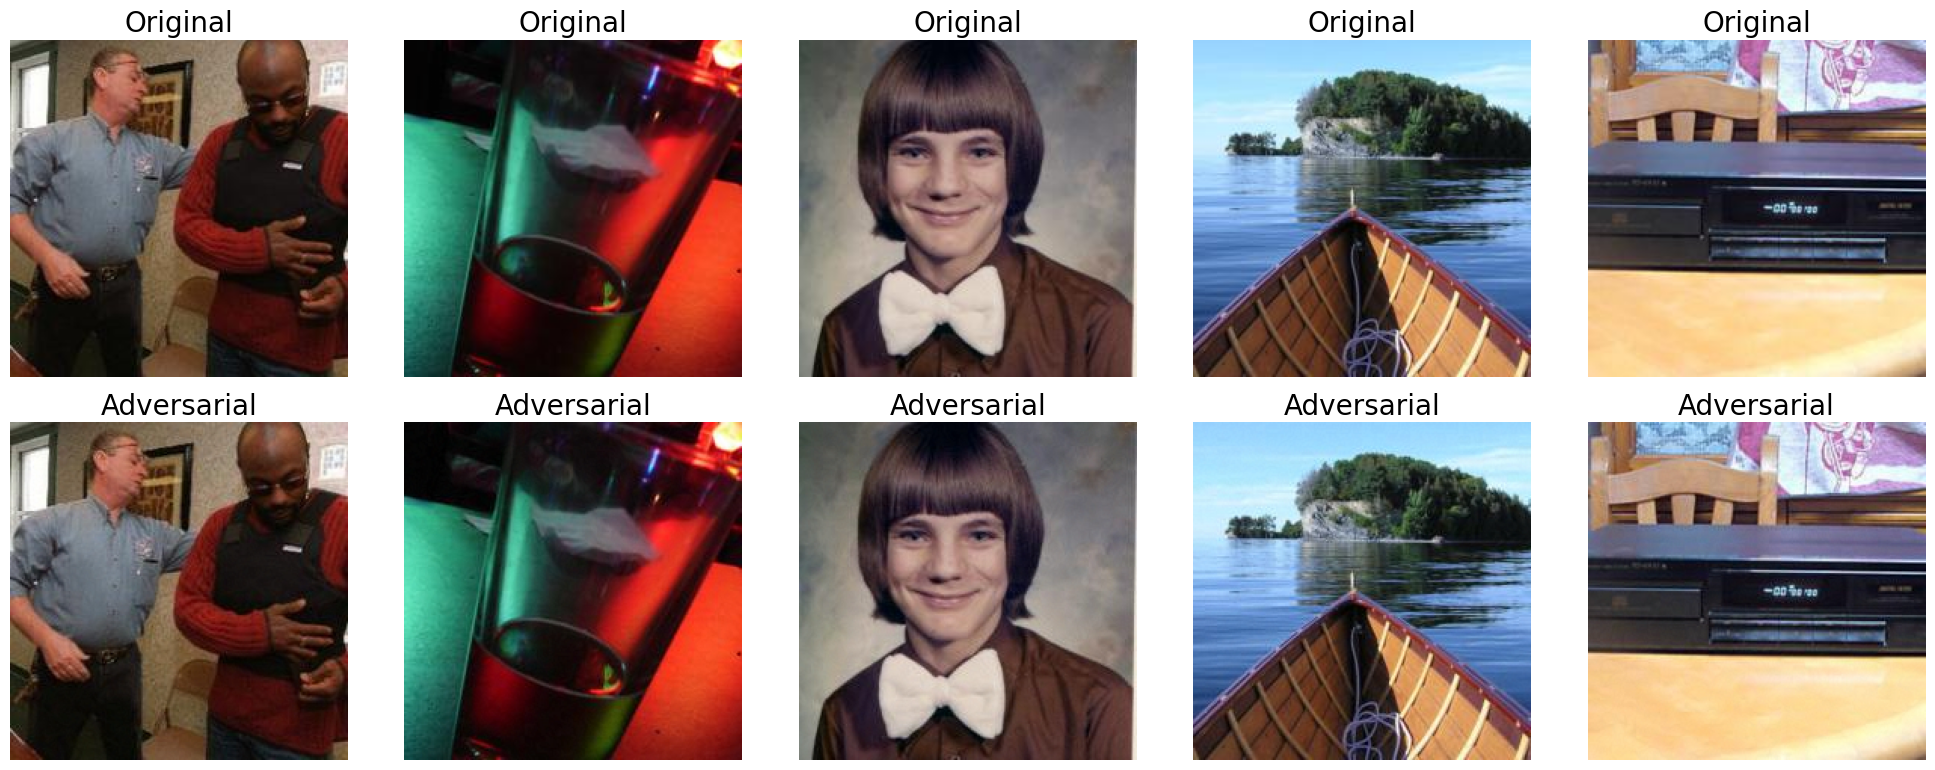

In [29]:
visualize_samples(dataset, adversarial_test_set_1)

Task 3: Improved attacks

In [17]:
def pgd_attack(model, image, label, epsilon=0.02, alpha=0.002, steps=10):
    model = model.to(device).eval()
    ori_image = image.clone().detach().to(device)
    adv_image = ori_image.clone().detach().requires_grad_(True)
    label = label.to(device)

    for _ in range(steps):
        outputs = model(adv_image)
        loss = torch.nn.functional.cross_entropy(outputs, label)
        
        model.zero_grad()
        loss.backward()
        
        adv_image = adv_image + alpha * adv_image.grad.sign()
        adv_image = torch.clamp(adv_image, ori_image - epsilon, ori_image + epsilon)
        adv_image = adv_image.detach().requires_grad_(True)

    return adv_image.detach()


In [19]:
attack_configs = [
    {"epsilon": 0.02, "alpha": 0.002, "steps": 10},
    {"epsilon": 0.02, "alpha": 0.004, "steps": 15},
    {"epsilon": 0.02, "alpha": 0.003, "steps": 20},
    {"epsilon": 0.02, "alpha": 0.004, "steps": 20},
    {"epsilon": 0.02, "alpha": 0.005, "steps": 30}
]

adversarial_test_set_list = []  

for config_idx, config in enumerate(attack_configs):
    print(f"\nRunning attack {config_idx+1}/{len(attack_configs)}")
    print("Current Attack Config:", config)
    print("-" * 40)
    
    adv_images_1 = []
    adv_labels_1 = []
    
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        img = img.unsqueeze(0).to(device)
        label_tensor = torch.tensor([label]).to(device)
        
        adv_img = pgd_attack(pretrained_model, img, label_tensor, **config)
        
        adv_images_1.append(adv_img.squeeze(0).detach().cpu())
        adv_labels_1.append(label)
    
    adversarial_test_set_2 = TensorDataset(torch.stack(adv_images_1), torch.tensor(adv_labels_1))
    Adversarial_Test_Set_2 = DataLoader(adversarial_test_set_2, batch_size=32, shuffle=False)
    adversarial_test_set_list.append(adversarial_test_set_2)
    
    acc = evaluate_topk(pretrained_model, Adversarial_Test_Set_2)
    
    print("\nAccuracy Drop from Baseline:")
    print(f"Top-1: {baseline_acc[0] - acc[0]:.4f}%")
    print(f"Top-5: {baseline_acc[1] - acc[1]:.4f}%")
    
    evaluate_perturbation(dataset, adversarial_test_set_2)
    
    print("=" * 40)

print("\nAll attacks completed.")



Running attack 1/5
Current Attack Config: {'epsilon': 0.02, 'alpha': 0.002, 'steps': 10}
----------------------------------------
Top 1 - Accuracy: 0.2000%
Top 5 - Accuracy: 13.6000%

Accuracy Drop from Baseline:
Top-1: 75.8000%
Top-5: 80.6000%
[Perturbation Evaluation]
  • Maximum pixel-wise difference across dataset: 0.020000
  • Average maximum difference per image: 0.000040
  • Mean per-pixel difference across all samples: 0.020000

Running attack 2/5
Current Attack Config: {'epsilon': 0.02, 'alpha': 0.004, 'steps': 15}
----------------------------------------
Top 1 - Accuracy: 0.0000%
Top 5 - Accuracy: 9.2000%

Accuracy Drop from Baseline:
Top-1: 76.0000%
Top-5: 85.0000%
[Perturbation Evaluation]
  • Maximum pixel-wise difference across dataset: 0.020000
  • Average maximum difference per image: 0.000040
  • Mean per-pixel difference across all samples: 0.020000

Running attack 3/5
Current Attack Config: {'epsilon': 0.02, 'alpha': 0.003, 'steps': 20}
-----------------------------

In [22]:
Adversarial_Test_Set_2 = DataLoader(adversarial_test_set_list[4], batch_size=32, shuffle=False)
torch.save(Adversarial_Test_Set_2, 'Adversarial_Test_Set_2.pt')

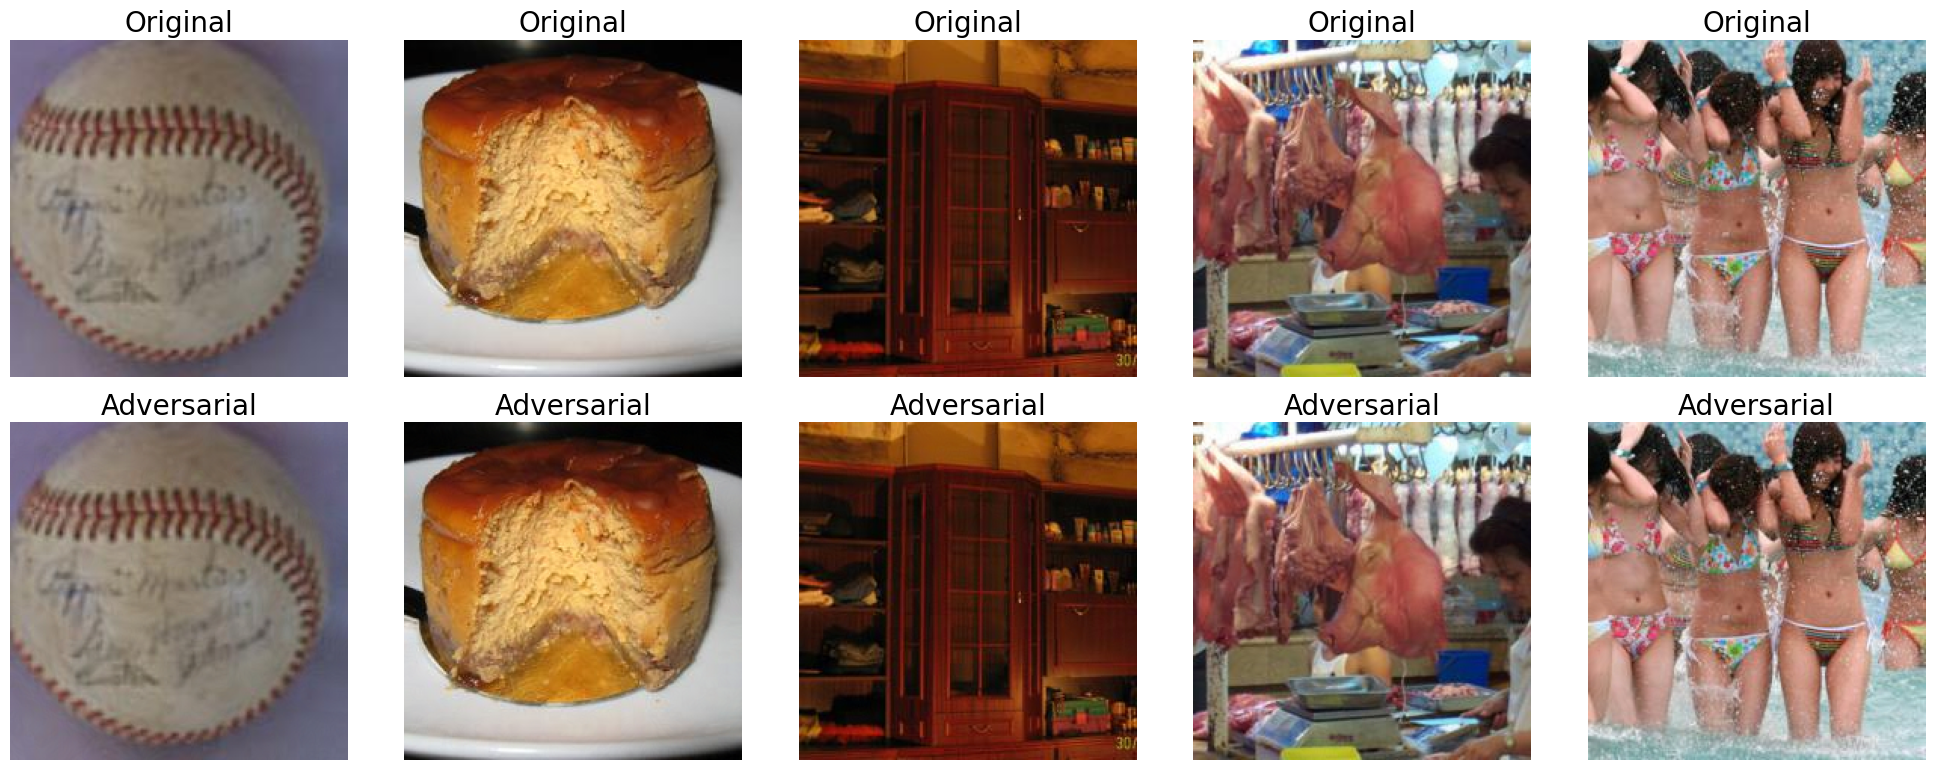

In [30]:
visualize_samples(dataset, adversarial_test_set_list[4])

Task 4: Patch attacks

In [32]:
import torch
import random

def fgsm_patch_attack(model, image, label, patch_dim=32, eps=0.3):
    model = model.to(device).eval()
    image = image.clone().detach().to(device).requires_grad_(True)
    label = label.to(device)

    _, _, height, width = image.shape

    # 随机位置采样
    top = random.randint(0, height - patch_dim)
    left = random.randint(0, width - patch_dim)

    outputs = model(image)

    # 这里使用 log_softmax + NLLLoss
    log_probs = torch.log_softmax(outputs, dim=1)
    loss_fn = torch.nn.NLLLoss()
    loss = loss_fn(log_probs, label)

    model.zero_grad()
    loss.backward()

    gradients = image.grad

    patch_mask = torch.zeros_like(gradients)
    patch_mask[:, :, top:top + patch_dim, left:left + patch_dim] = 1.0

    patch_perturb = eps * gradients.sign() * patch_mask
    adversarial_image = image + patch_perturb

    return adversarial_image.detach()


In [33]:
from tqdm import tqdm

adv_images_2 = []
adv_labels_2 = []

for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    img = img.unsqueeze(0)

    label_tensor = torch.tensor([label])

    adv_img = fgsm_patch_attack(pretrained_model, img, label_tensor)
    adv_images_2.append(adv_img.squeeze(0).detach().cpu())
    adv_labels_2.append(label)

adversarial_test_set_3 = TensorDataset(torch.stack(adv_images_2), torch.tensor(adv_labels_2))
Adversarial_Test_Set_3 = DataLoader(adversarial_test_set_list[4], batch_size=32, shuffle=False)
torch.save(Adversarial_Test_Set_3, 'Adversarial_Test_Set_3.pt')
task_acc = evaluate_topk(pretrained_model, Adversarial_Test_Set_3)

print("\nAccuracy Drop from Baseline")
print(f"Top-1: {baseline_acc[0] - task_acc[0]}%")
print(f"Top-5: {baseline_acc[1] - task_acc[1]}%")

evaluate_perturbation(dataset, adversarial_test_set_3)

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 65.88it/s]


Top 1 - Accuracy: 1.4000%
Top 5 - Accuracy: 10.2000%

Accuracy Drop from Baseline
Top-1: 74.6%
Top-5: 84.0%
[Perturbation Evaluation]
  • Maximum pixel-wise difference across dataset: 0.300000
  • Average maximum difference per image: 0.000600
  • Mean per-pixel difference across all samples: 0.300000


(0.30000007152557373, 0.0006000001430511475, 0.3000000701546669)

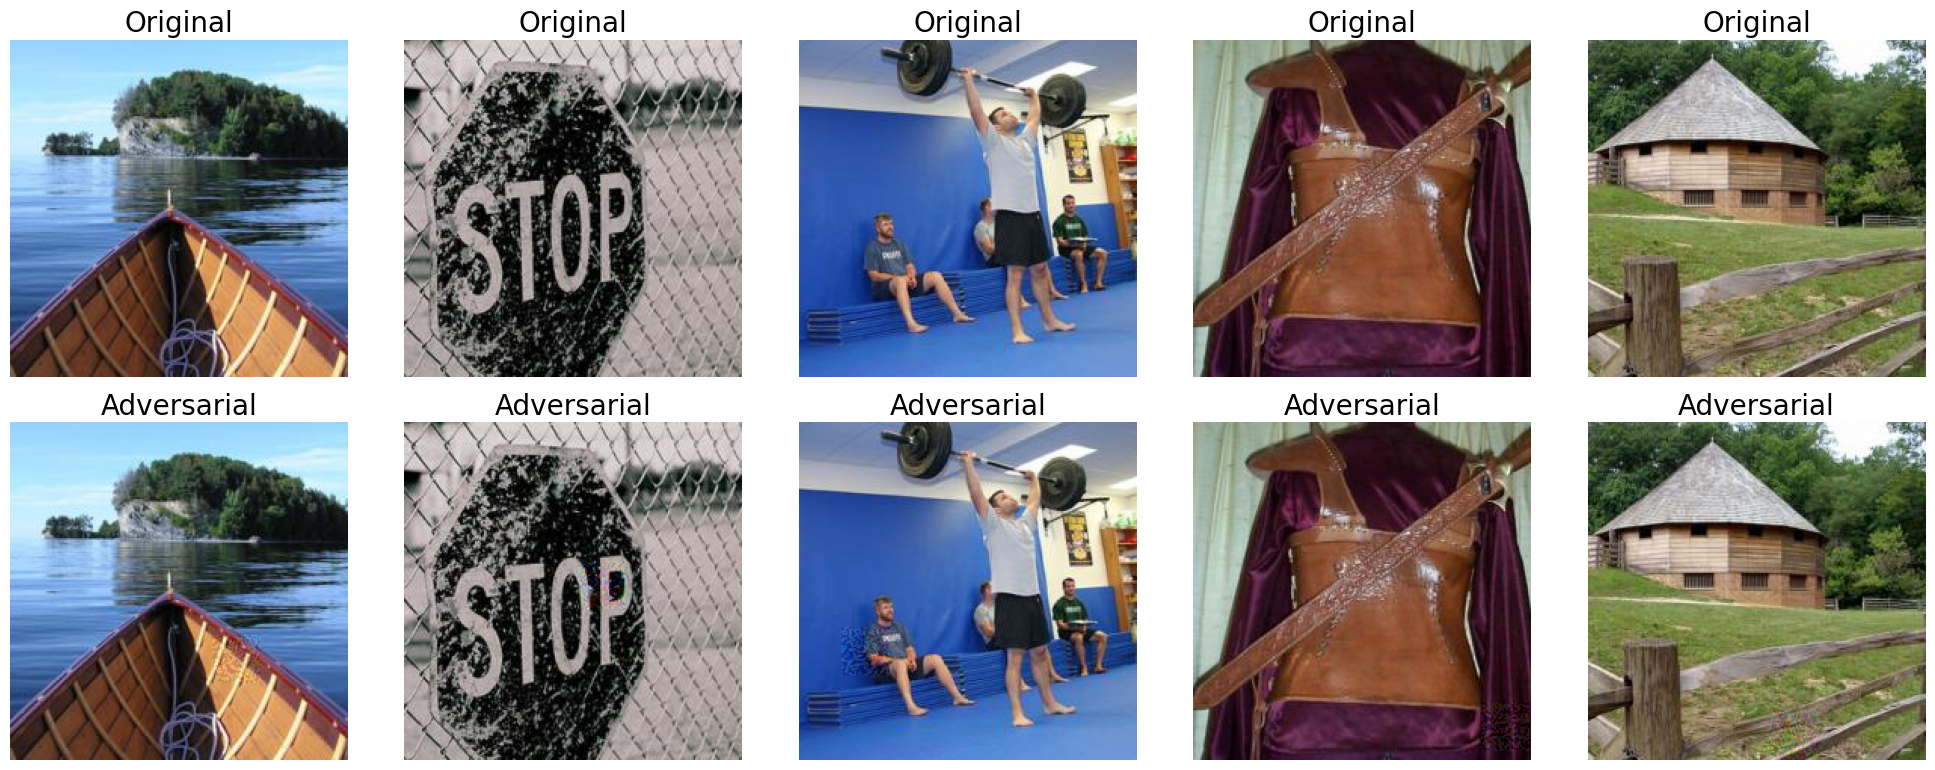

In [34]:
visualize_samples(dataset, adversarial_test_set_3)

Task 5: Transferring attacks

In [37]:

transfer_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1).to(device)


List_name = ["Original", "fgsm_attack", "pgd_attack", "fgsm_patch_attack"]


List_data = ["dataloader", "Adversarial_Test_Set_1", "Adversarial_Test_Set_2", "Adversarial_Test_Set_3"]

for i in range(4):
    dataset = torch.load(f"{List_data[i]}.pt")  # Load dataset from file
    print(f"\n{List_name[i]} on resnet34")
    evaluate_topk(pretrained_model, dataset)  # Evaluate using ResNet34
    print(f"\n{List_name[i]} on densenet121")
    evaluate_topk(transfer_model, dataset)    # Evaluate using DenseNet121






Original on resnet34
Top 1 - Accuracy: 76.0000%
Top 5 - Accuracy: 94.2000%

Original on densenet121
Top 1 - Accuracy: 74.6000%
Top 5 - Accuracy: 93.6000%

fgsm_attack on resnet34
Top 1 - Accuracy: 6.0000%
Top 5 - Accuracy: 35.4000%

fgsm_attack on densenet121
Top 1 - Accuracy: 63.6000%
Top 5 - Accuracy: 89.0000%

pgd_attack on resnet34
Top 1 - Accuracy: 0.2000%
Top 5 - Accuracy: 8.4000%

pgd_attack on densenet121
Top 1 - Accuracy: 63.4000%
Top 5 - Accuracy: 91.0000%

fgsm_patch_attack on resnet34
Top 1 - Accuracy: 1.4000%
Top 5 - Accuracy: 10.2000%

fgsm_patch_attack on densenet121
Top 1 - Accuracy: 63.4000%
Top 5 - Accuracy: 91.0000%
